### Initial Imports

Installing the compatible versions of keras and tensorflow

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip install tf_keras==2.15.1 -q

!pip install tensorflow==2.15.0 -q

!pip install keras-cv==0.6.0 -q

!pip install keras-core -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.68 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━

Checking tensorflow version

In [2]:
import tensorflow as tf
import tf_keras as keras

!nvidia-smi
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
!nvcc --version
#

Mon Dec  2 01:25:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Importing keras_cv models

In [3]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder

Using TensorFlow backend


### Getting Instance and Class Images

Instance Images: these are the 5 images that we are fine-tuning the model on

Class Images: these are 200 images generated by the model before fine-tuning

Generating Class Images script: https://colab.research.google.com/drive/18TBf7D02EsjLYDGNguzp9Ir9MM8748VR?usp=sharing

### Loading and Visualizing Images

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


Loading image paths

In [5]:
from imutils import paths

instance_images_root = '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_instance_images'
class_images_root = '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_class_images'

instance_image_paths = list(paths.list_images(instance_images_root))
class_image_paths = list(paths.list_images(class_images_root))

instance_image_paths, class_image_paths[:5]

(['/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_instance_images/yosemite_1.jpeg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_instance_images/yosemite_2.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_instance_images/yosemite_4.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_instance_images/yosemite_3.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_instance_images/yosemite_5.jpg'],
 ['/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_class_images/5a66fd9bc1fbf74e5d0cd73bc974c45e526f23f5.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_class_images/a2496e7a77d076871f3d7bacd20907e0fda39b2e.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosemite_class_images/c8e7fa568ac7912c21c7162bb5ab9f9af3785951.jpg',
  '/content/drive/MyDrive/DeepLearning/dataset/macOS_wallpapers/yosem

Creating a function that loads images from the paths

In [6]:
from PIL import Image
import numpy as np

def load_images(image_paths):
    images = []
    for path in image_paths:
        image = Image.open(path)
        images.append(np.array(image))
    return images

Creating a function to plot the loaded images

In [7]:
import matplotlib.pyplot as plt

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

**Instance Images**

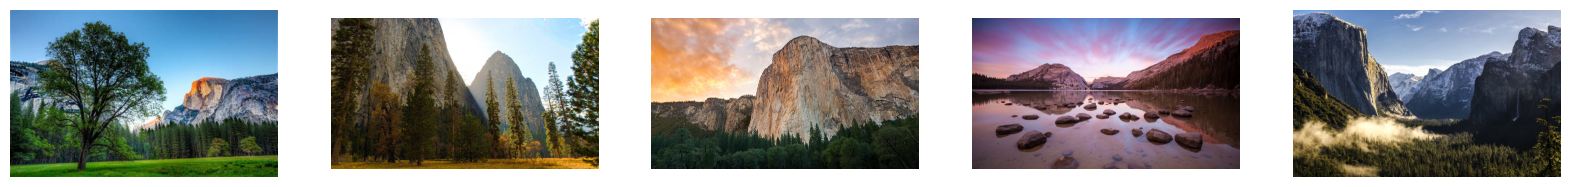

In [8]:
plot_images(load_images(instance_image_paths[:5]))

**Class Images**

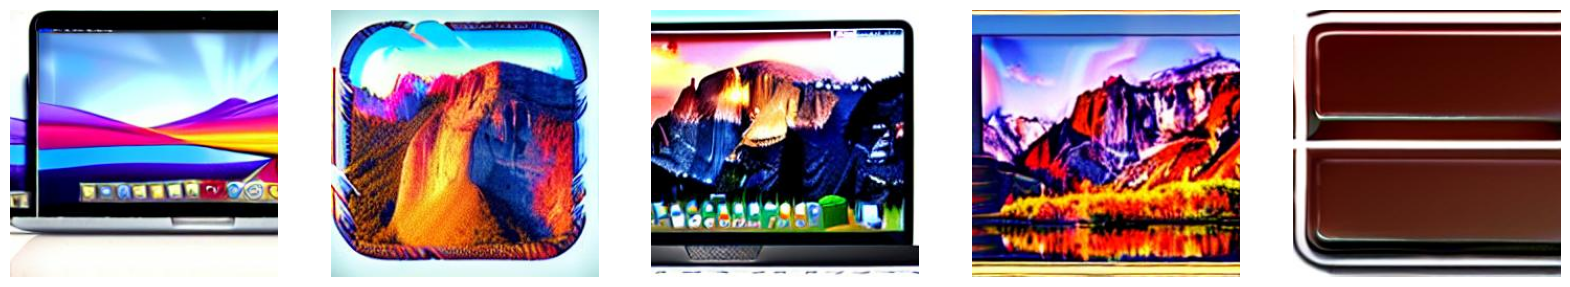

In [9]:
plot_images(load_images(class_image_paths[:5]))

### Preparing the datasets

This involves 2 stages: 1, preparing the captions, and 2, processing the images

#### Preparing Captions

In [10]:
# Since we're using prior preservation, we need to match the number
# of instance images we're using. We just repeat the instance image paths
# to do so.
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

In [11]:
# We just repeat the prompts / captions per images.
unique_id = "sks"
class_label = "yosemite"

instance_prompt = f"an image of {unique_id} {class_label}"
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"an image of {class_label}"
class_prompts = [class_prompt] * len(class_image_paths)

Embedding prompts to save compute

In [12]:
import numpy as np
import itertools

# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(instance_prompts) + len(class_prompts), max_prompt_length))

for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)


# We also pre-compute the text embeddings to save some memory during training.
POS_IDS = tf.convert_to_tensor([list(range(max_prompt_length))], dtype=tf.int32)
text_encoder = TextEncoder(max_prompt_length)

gpus = tf.config.list_logical_devices("GPU")

# Ensure the computation takes place on a GPU.
with tf.device(gpus[0].name):
    embedded_text = text_encoder(
        [tf.convert_to_tensor(tokenized_texts), POS_IDS], training=False
    ).numpy()

# To ensure text_encoder doesn't occupy any GPU space.
del text_encoder

492466864/492466864 [==============================] - 3s 0us/step


#### Preparing Images

In [13]:
import keras_cv

resolution = 256
auto = tf.data.AUTOTUNE

augmenter = tf.keras.Sequential([
        keras_cv.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
])


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, embedded_tokens):
    return augmenter(image_batch), embedded_tokens


def prepare_dict(instance_only=True):
    def fn(image_batch, embedded_tokens):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_embedded_texts": embedded_tokens,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_embedded_texts": embedded_tokens,
            }
            return batch_dict
    return fn


def assemble_dataset(
    image_paths, embedded_texts, instance_only=True, batch_size=1
):
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths, embedded_texts)
    )
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset

#### Assembling Dataset

In [14]:
instance_dataset = assemble_dataset(
    new_instance_image_paths,
    embedded_text[:len(new_instance_image_paths)],
)
class_dataset = assemble_dataset(
    class_image_paths,
    embedded_text[len(new_instance_image_paths):],
    instance_only=False
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

#### Checking Shapes

Checking what's inside the dataset

In [15]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

dict_keys(['instance_images', 'instance_embedded_texts']) dict_keys(['class_images', 'class_embedded_texts'])


In [16]:
for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

instance_images (1, 256, 256, 3)
instance_embedded_texts (1, 77, 768)


In [17]:
for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

class_images (1, 256, 256, 3)
class_embedded_texts (1, 77, 768)


### DreamBooth Training Loop

In [18]:
import tensorflow.experimental.numpy as tnp

class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_embedded_text = instance_batch["instance_embedded_texts"]
        class_images = class_batch["class_images"]
        class_embedded_text = class_batch["class_embedded_texts"]

        images = tf.concat([instance_images, class_images], 0)
        embedded_texts = tf.concat([instance_embedded_text, class_embedded_text], 0)
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts], training=True
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly.
        model_pred, model_pred_prior = tf.split(model_pred, num_or_size_splits=2, axis=0)
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

### Trainer Initialization

In [19]:
# Comment it if you are not using a GPU having tensor cores.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [20]:
use_mp = True # Set it to False if you're not using a GPU with tensor cores.

model = keras_cv.models.StableDiffusion(img_height=resolution, img_width=resolution)

image_encoder = model.image_encoder
dreambooth_trainer = DreamBoothTrainer(
    diffusion_model=DiffusionModel(resolution, resolution, max_prompt_length),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=use_mp,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://github.com/huggingface/diffusers/tree/main/examples/dreambooth
lr = 5e-6
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x78e454652fb0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x78e454652fb0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3439090152/3439090152 [==============================] - 18s 0us/step


### Training

Calculate number of epochs to train for:

In [21]:
import math

num_update_steps_per_epoch = train_dataset.cardinality()
max_train_steps = 800
epochs =  math.ceil(max_train_steps / num_update_steps_per_epoch)
print(f"Training for {epochs} epochs.")

Training for 4 epochs.


Training:

In [22]:
ckpt_path = "dreambooth-unet.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/4


Instructions for updating:
Use fn_output_signature instead


200/200 [==============================] - 380s 377ms/step - loss: 0.1306
Epoch 2/4
200/200 [==============================] - 76s 379ms/step - loss: 0.1417
Epoch 3/4
200/200 [==============================] - 80s 396ms/step - loss: 0.1257
Epoch 4/4
200/200 [==============================] - 77s 383ms/step - loss: 0.1174


### Inference

In [23]:
# Initialize a new Stable Diffusion model.
dreambooth_model = keras_cv.models.StableDiffusion(
    img_width=resolution, img_height=resolution, jit_compile=True
)
dreambooth_model.diffusion_model.load_weights(ckpt_path)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


198180272/198180272 [==============================] - 1s 0us/step


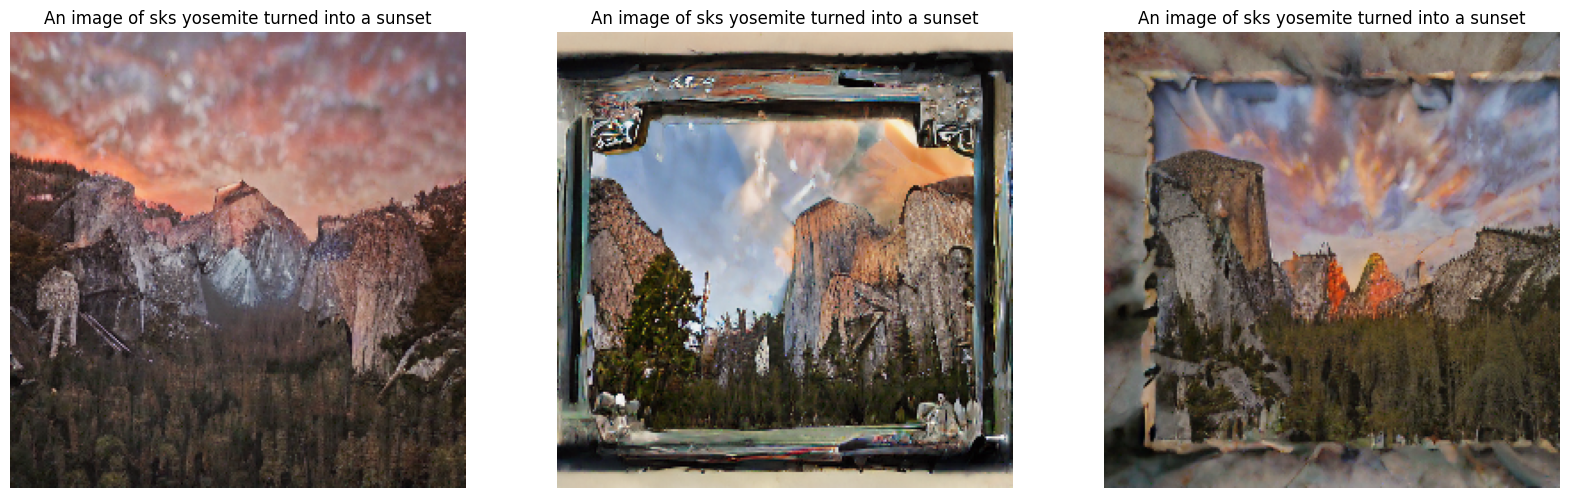

In [24]:
# Note how the unique idenitifer and the class have been used in the prompt.
prompt = f"An image of sks yosemite turned into a sunset"
num_imgs_to_gen = 3

generated_img = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_images(generated_img, prompt)